In [1]:
import swyft

import numpy as np
import pickle

import seaborn as sns
from scipy import stats
from matplotlib.axes import Axes
from typing import Optional, Sequence, Tuple, Union

import matplotlib.pyplot as plt
font = {"weight": "normal", "size": 12, "family": "STIXGeneral"}
axislabelfontsize = "large"
plt.rc("font", **font)
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["text.usetex"] = True

In [2]:
cmap = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=True)

In [3]:
file = open("./../Inference/01_output/coverageData.pkl", "rb")
coverage_samples = pickle.load(file)
file.close()

In [4]:
def get_alpha(z_score: Union[float, np.ndarray]) -> np.ndarray:
    """Recover the alpha (significance level) given by `alpha = 2 * (1 - normal_cdf(z_score))`.
    Args:
        z_score: z_score aka `z`
    Returns:
        alpha: significance level
    """
    return 2 * (1 - stats.norm.cdf(z_score))

def plot_empirical_z_score(
    axes: Axes,
    nominal_z_scores: np.ndarray,
    z_mean: np.ndarray,
    z_interval: np.ndarray,
    mean_color: str = "black",
    interval_color: str = "0.8",
    diagonal_color: str = "darkgreen",
    sigma_color: str = "red",
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    xlabel: Optional[str] = r"Empirical coverage [$z_p$]",
    ylabel: Optional[str] = r"Nominal credibility [$z_p$]",
    diagonal_text: bool = False,
    fsize: int = 12,
    lw_horizonal=1,
    lw_vertical=1,
    lw_empirical=1,
    lw_diagonal=1
) -> Axes:
    """target a particular matplotlib Axes and produce an empirical coverage test plot with Jeffrey's interval
    Args:
        axes: matplotlib axes
        nominal_z_scores: sorted array of nominal z-scores
        z_mean: empirical mean of z-score estimate using a binominal distribution
        z_interval: jeffrey's interval of z-score estimate
        mean_color: color of the mean line.
        interval_color: color of the interval, floats are grey.
        diagonal_color: color of the diagonal, nominal z-score.
        sigma_color: color of the vertical and horizontal sigma lines.
        xlim: force xlim
        ylim: force ylim
        xlabel: set xlabel
        ylabel: set ylabel
        diagonal_text: turns on semantic description of above / below diagonal
    Returns:
        the matplotlib axes given
    """
    lower = z_interval[:, 0]
    upper = z_interval[:, 1]
    assert np.all(lower <= upper), "the lower interval must be <= the upper interval."
    upper = np.where(upper == np.inf, 100.0, upper)

    # empirical lines & interval
    axes.plot(nominal_z_scores, z_mean, color=mean_color, lw=lw_empirical)
    axes.fill_between(nominal_z_scores, lower, upper, color=interval_color)

    # diagonal line
    max_z_score = np.max(nominal_z_scores)
    axes.plot([0, max_z_score], [0, max_z_score], "--", color=diagonal_color, lw=lw_diagonal)

    # horizontal and vertical lines, vertical are the "truth", horizontal are empirical
    for i_sigma in range(1, int(max_z_score) + 1):
        empirical_i_sigma = np.interp(i_sigma, nominal_z_scores, z_mean)
        if empirical_i_sigma != np.inf:  # when the vertical line intersects z_mean
            # Horizontal line
            axes.plot(
                [0, i_sigma],
                [empirical_i_sigma, empirical_i_sigma],
                ":",
                color=sigma_color,
                lw=lw_horizonal
            )
            # horizontal text
            c = 1 - get_alpha(empirical_i_sigma)
            axes.text(0.15, empirical_i_sigma + 0.05, (r"$%.2f$" % (c * 100)) + "$\%$", fontsize=fsize)
            # vertical line
            axes.plot(
                [i_sigma, i_sigma], [0, empirical_i_sigma], ":", color=sigma_color, lw=lw_vertical
            )
            # vertical text
            c = 1 - get_alpha(i_sigma)
            axes.text(i_sigma, 0.15, (r"$%.2f$" % (c * 100)) + "$\%$", rotation=-90, fontsize=fsize)
        else:  # when the vertical line fails to intersect z_mean
            pass

    # set labels
    axes.set_ylabel(xlabel)
    axes.set_xlabel(ylabel)

    # Add the semantic meaning of being above / below diagonal
    if diagonal_text:
        raise NotImplementedError("must add rotation description")

    # set limits
    if xlim is None:
        axes.set_xlim([0, max_z_score])
    else:
        axes.set_xlim(xlim)

    if ylim is None:
        axes.set_ylim([0, max_z_score + np.round(0.15 * max_z_score, 1)])
    else:
        axes.set_ylim(ylim)
    return axes

In [5]:
def coveragePlot():
    fig, ax = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True) #, constrained_layout=True)
    labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
                r'$\log_{10}(L_{\rm X})$', r'$E_0$', r'$\alpha_{\rm X}$']
    cn = 0
    lower_lim = 1
    for i in range(0, 5):     
        for j in range(lower_lim, 6):         
            cov = swyft.estimate_coverage(coverage_samples, coverage_samples[1].parnames[cn].tolist())
            plot_empirical_z_score(ax[j, i], cov[:, 0], cov[:, 1], cov[:, 2:], xlabel="", ylabel="", mean_color=cmap(0.999),
                               interval_color=cmap(0.2), sigma_color="grey", diagonal_color="g", fsize=6,
                               lw_horizonal=0.5, lw_vertical=0.5, lw_diagonal=0.5)
            cn += 1     
        lower_lim+=1      

    for i in range(6):
        for j in range(6):
            ax[i, j].tick_params(axis='both', which='major', labelsize=8, length=3)
            ax[i, j].tick_params(axis='both', which='minor', labelsize=8, length=2)
            if j > i:
                ax[i, j].set_axis_off()
            ax[i, j].set_xticks([0, 1, 2, 3])
            if i == j:
                cov = swyft.estimate_coverage(coverage_samples, "z[%d]"%i)
                plot_empirical_z_score(ax[i, j], cov[:, 0], cov[:, 1], cov[:, 2:], xlabel="", ylabel="", mean_color=cmap(0.999),
                                       interval_color=cmap(0.2), sigma_color="grey", diagonal_color="g", fsize=6,
                                       lw_horizonal=0.5, lw_vertical=0.5, lw_diagonal=0.5)

    for i in range(len(labels)):
        ax[i, 0].set_ylabel(labels[i], fontsize=12)
        ax[-1, i].set_xlabel(labels[i], fontsize=12)
        ax[i, 0].get_yaxis().set_label_coords(-0.25, 0.5)
        ax[-1, i].get_xaxis().set_label_coords(0.5, -0.25)
    ax[0, 0].set_ylabel("")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.align_xlabels()
    fig.align_ylabels()

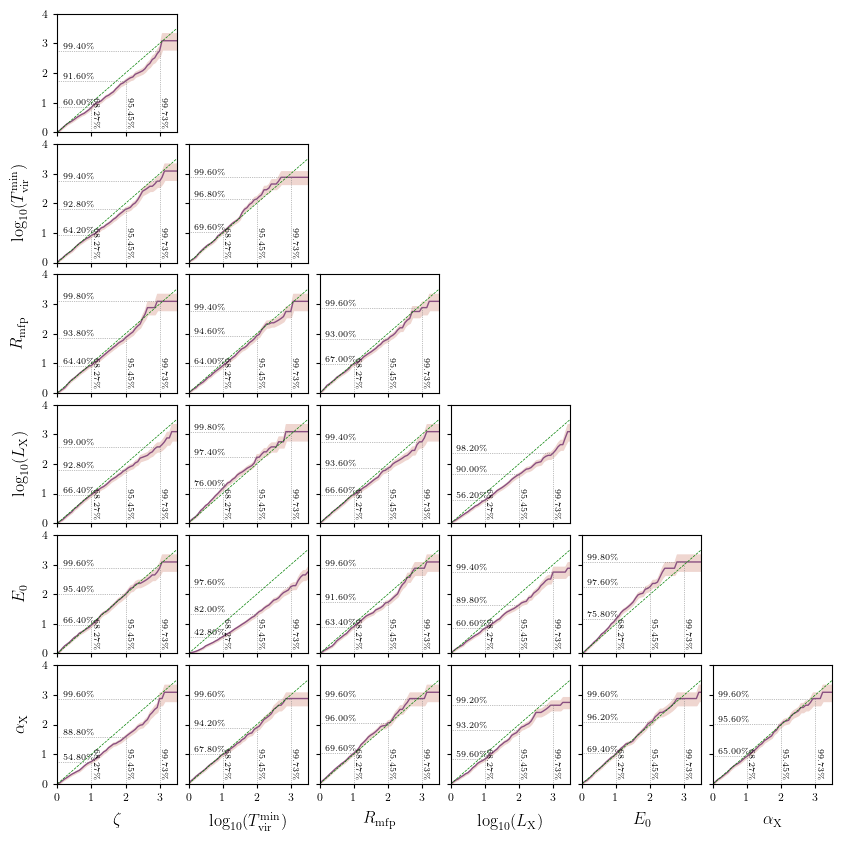

In [6]:
coveragePlot()
plt.savefig("./plots/03_coverage.pdf", bbox_inches="tight")